# Projet Fraude bancaire propre : Création des modèles

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

In [2]:
os.getcwd()

'/home/elisa/Documents/M2_SISE/BigDataMining/Projet_Fraude'

## I. Importation du dataset
Le pré-traitement du dataset a déjà été fait en amont. Nous importons donc directement le fichier au format dask à partir d'un format parquet.

In [3]:
df = dd.read_parquet('guillaumeb_parquet')
df.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## II. Subdivision en apprentissage/test
 - dfTrain : du 2017-02-01 au 2017-08-31
 - dfTest : du 2017-09-01 au 2017-11-30

In [4]:
# Canger le type de la variable "CodeDecision"
df['CodeDecision'] = df['CodeDecision'].astype('object')

In [5]:
dfTrain = df.loc[df['Date'] <= '2017-08-31']
dfTest = df.loc[df['Date'] >= '2017-09-01']
dfTrain.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## III. Définir la variable cible (y) et les variables explicatives (X)

In [6]:
# Définir la variable cible 
yTrain = dfTrain["FlagImpaye"]
yTest = dfTest["FlagImpaye"]

In [7]:
# Définir les variables explicatives 
XTrain = dfTrain.drop(["FlagImpaye", "Date", "Heure"], axis = "columns")
XTest = dfTest.drop(["FlagImpaye", "Date", "Heure"], axis = "columns")

## IV. Recodage de la variable "CodeDecision" dans les varaibles explicatives
- Rmq : La variable qualitative "CodeDecision" possède les modalités 0, 1, 2 et 3 dans dfTrain et les modalités 0, 2 et 3 dans dfTest. 
- Notre stratégie est la suivante : 
    1. Recodage de la variable "CodeDecision" dans les variables explicatives XTrain et XTest.
    2. Comme la variable "CodeDecision_1" n'est présente que dans XTrain, elle devient inutile. Nous décidons donc de la supprimer.

In [8]:
# Exposition du problème 
print("Dans le dataframe d'apprentissage :")
print(dfTrain['CodeDecision'].value_counts().compute())
print("-------------------------------------------------------")
print("Dans le dataframe de test :")
print(dfTest['CodeDecision'].value_counts().compute())

Dans le dataframe d'apprentissage :
0    2760391
1    1121626
2      15138
3       2207
Name: CodeDecision, dtype: int64
-------------------------------------------------------
Dans le dataframe de test :
0    742395
2      4424
3       591
Name: CodeDecision, dtype: int64


In [9]:
# 1) Recodage de la variable "CodeDecision" dans les variables explicatives 
XTrain_ok = dd.get_dummies(XTrain.categorize(), prefix=['CodeDecision'])
XTest_ok = dd.get_dummies(XTest.categorize(), prefix=['CodeDecision'])

# 2) Supprimer la variable "CodeDecision_1" de dfTrain
XTrain_ok = XTrain_ok.drop(["CodeDecision_1"], axis = "columns")
XTrain_ok.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,1,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,0,0,0


## IV. Algorithmes

In [10]:
def Calcul_CA(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable CA
    dfmerge["CA"] = dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "CA"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "CA"] = 0.8 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "CA"] = 1 - np.exp(1/dfmerge["Montant"])
    
    # Calcul du CA_total
    CA_total = dfmerge["CA"].sum()
    
    return CA_total

In [11]:
"""Création de la fonction de déploiement d'un modèle sur les données de test"""

def deploiement(modele, XTest, yTest):
    print("-------------------------------------------------------")
    # Importation du modèle 
    fichier = open(modele, "rb")
    mdl = pickle.load(fichier)
    fichier.close()
    
    # Affichage du modèle 
    print('Modèle :\n', mdl)
    print("-------------------------------------------------------")
    # Prédiction
    Ypred = delayed(mdl.predict)(XTest).compute()
    # Prédiction des scores
    Yscore = delayed(mdl.predict_proba)(XTest).compute()
    
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(yTest, Ypred)
    cr = delayed(classification_report)(yTest, Ypred)
    auc = delayed(roc_auc_score)(yTest, Ypred)

    print('Estimateurs :\n', cr.compute())
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm.compute())
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc.compute())
    print("-------------------------------------------------------")
    
    # BONUS :  Calcul du chiffre d'affaire
    CA_total = Calcul_CA(Montant = XTest["Montant"].compute(), yReel = yTest.compute(), yPred = Ypred)
    print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
    print("-------------------------------------------------------")

    # Courbe ROC
    skplt.metrics.plot_roc(yTest, Yscore, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(yTest, Yscore, classes_to_plot = 1, plot_micro = False)
    return CA_total

### -------- Algorithme n°1 : Arbre de décision --------

### a. Création, entrainement et exportation du modele

In [12]:
# Instanciation 
dtree = DecisionTreeClassifier(random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(dtree.fit)(XTrain_ok, yTrain)

In [13]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

DecisionTreeClassifier(random_state=0)


In [14]:
# Exportation du modèle 
f = open("modele1.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle 

-------------------------------------------------------
Modèle :
 DecisionTreeClassifier(random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.63      0.68      0.65      6573

    accuracy                           0.99    747410
   macro avg       0.81      0.84      0.83    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[738224   2613]
 [  2103   4470]]
-------------------------------------------------------
Auc Score :
 0.8382638389285995
-------------------------------------------------------
Chiffre d'affaire = 45829870.8 euros
-------------------------------------------------------


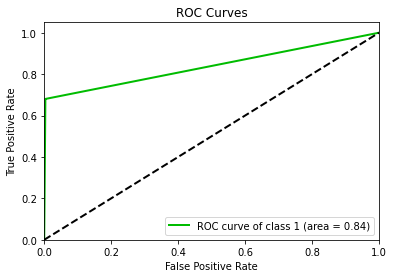

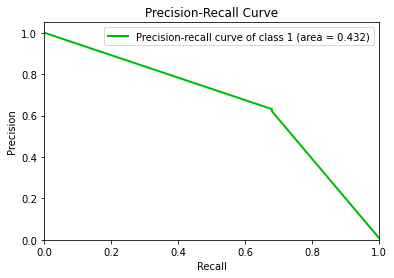

In [15]:
dep1 = deploiement(modele = "modele1.sav", XTest = XTest_ok, yTest = yTest)

### -------- Algorithme n°2 : RandomForest --------

### a. Création, entrainement et exportation du modele

In [16]:
# Instanciation 
RandomForest = RandomForestClassifier(n_estimators = 10, random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(RandomForest.fit)(XTrain_ok, yTrain)

In [17]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

RandomForestClassifier(n_estimators=10, random_state=0)


In [18]:
# Exportation du modèle 
f = open("modele2.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.98      0.67      0.80      6573

    accuracy                           1.00    747410
   macro avg       0.99      0.83      0.90    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740748     89]
 [  2177   4396]]
-------------------------------------------------------
Auc Score :
 0.8343382288653698
-------------------------------------------------------
Chiffre d'affaire = 45884788.83 euros
-------------------------------------------------------


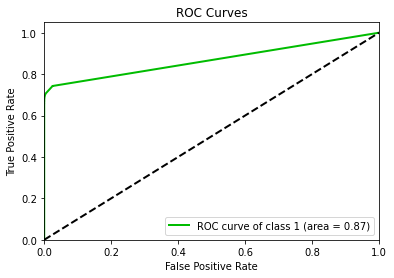

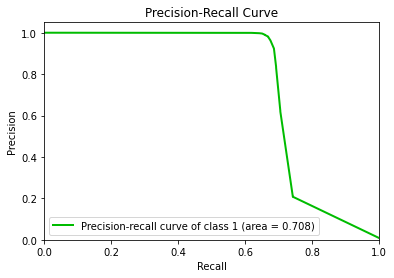

In [19]:
dep2 = deploiement(modele = "modele2.sav", XTest = XTest_ok, yTest = yTest)

## V. Comparaison des modèles

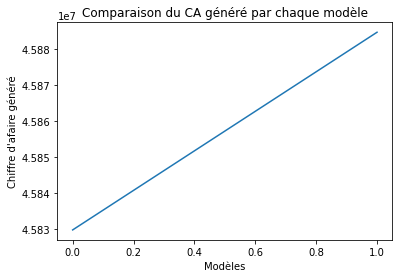

In [20]:
# Comparaison du CA généré par chaque modèle
plt.plot([dep1, dep2])
plt.ylabel("Chiffre d'afaire généré")
plt.xlabel("Modèles")
plt.title("Comparaison du CA généré par chaque modèle") 
plt.show()